In [1]:
# Authors: Daelon Kingore, Ashton Barnwell, Jacob Albrecht
# Stock Market prediction using Data Mining/AI algorithms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# set global dpiAmount for graph renders
dpiAmount = 200

# gather data from csv
ticker = "EXPE" # change this ticker value if you're using a different csv file
data = pd.read_csv(f'{ticker}.csv')

# drop unnecessary data
data = data.drop(["Adj Close"], axis=1)
data = data.drop(["Date"], axis=1)
data = data.drop(["Volume"], axis=1)

# close-open and hight-low were tested and determined bad for most models
# data['Close-Open'] =  data.Close - data.Open
# data['High-Low'] = data.High - data.Low
# newData = data[['Close-Open', 'High-Low']]

# using just the closing value is the best for the majority of the models - all others dropped
newData = data[['Close']]

# standardize data to allow more efficient and accurate processing
standardizer = StandardScaler()
dataStandardized = standardizer.fit_transform(newData)

# find y by seeing if next day is up or down
yRegress = data["Close"]

# using the train test split function. We are using both regression and classification
xTrain, xTest, yTrainRegress, yTestRegress = train_test_split(dataStandardized, yRegress, test_size=0.25, shuffle=False)
yTrainClass = np.where(yTrainRegress.shift(-1) > yTrainRegress, "Up", "Down") # ytrain
yTestClass = np.where(yTestRegress.shift(-1) > yTestRegress, "Up", "Down") # yTest

In [2]:
# functions to assist in graphing

# determines whether a prediction is right (green) or wrong (red)
def getColors(real, pred):
    if real == pred:
        return "green"
    else:
        return "red"
    
# gets arrow directions based what the prediction was
def getSymbols(pred):
    if pred == 'Up':
        return 6
    else:
        return 7

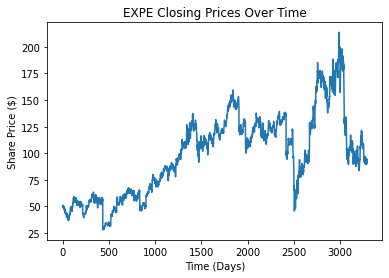

In [3]:
# view our starting data close prices
plt.plot(data['Close'])
plt.title(f"{ticker} Closing Prices Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
plt.show()

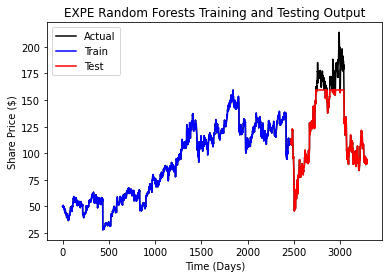

In [4]:
# Random Forest Model using regression (predicted monetary values)
randomForests = RandomForestRegressor(n_estimators=250, max_depth=9, bootstrap=False) # create model
rFRegress = randomForests.fit(xTrain, yTrainRegress) # train data

# train and test predictions
trainrFPredict = rFRegress.predict(xTrain)
testRFPredict = rFRegress.predict(xTest)

# create plottable data (shift test prediction to the correct place)
testPredictPlot = np.empty_like(data['Close'])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainrFPredict):len(data)] = testRFPredict

# Plot the test predictions
plt.plot(data['Close'], color="black", label=f"Actual")
plt.plot(trainrFPredict, color="blue", label=f"Train")
plt.plot(testPredictPlot, color="red", label=f"Test")
plt.title(f"{ticker} Random Forests Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
plt.legend()
plt.show()

0.5103280680437424


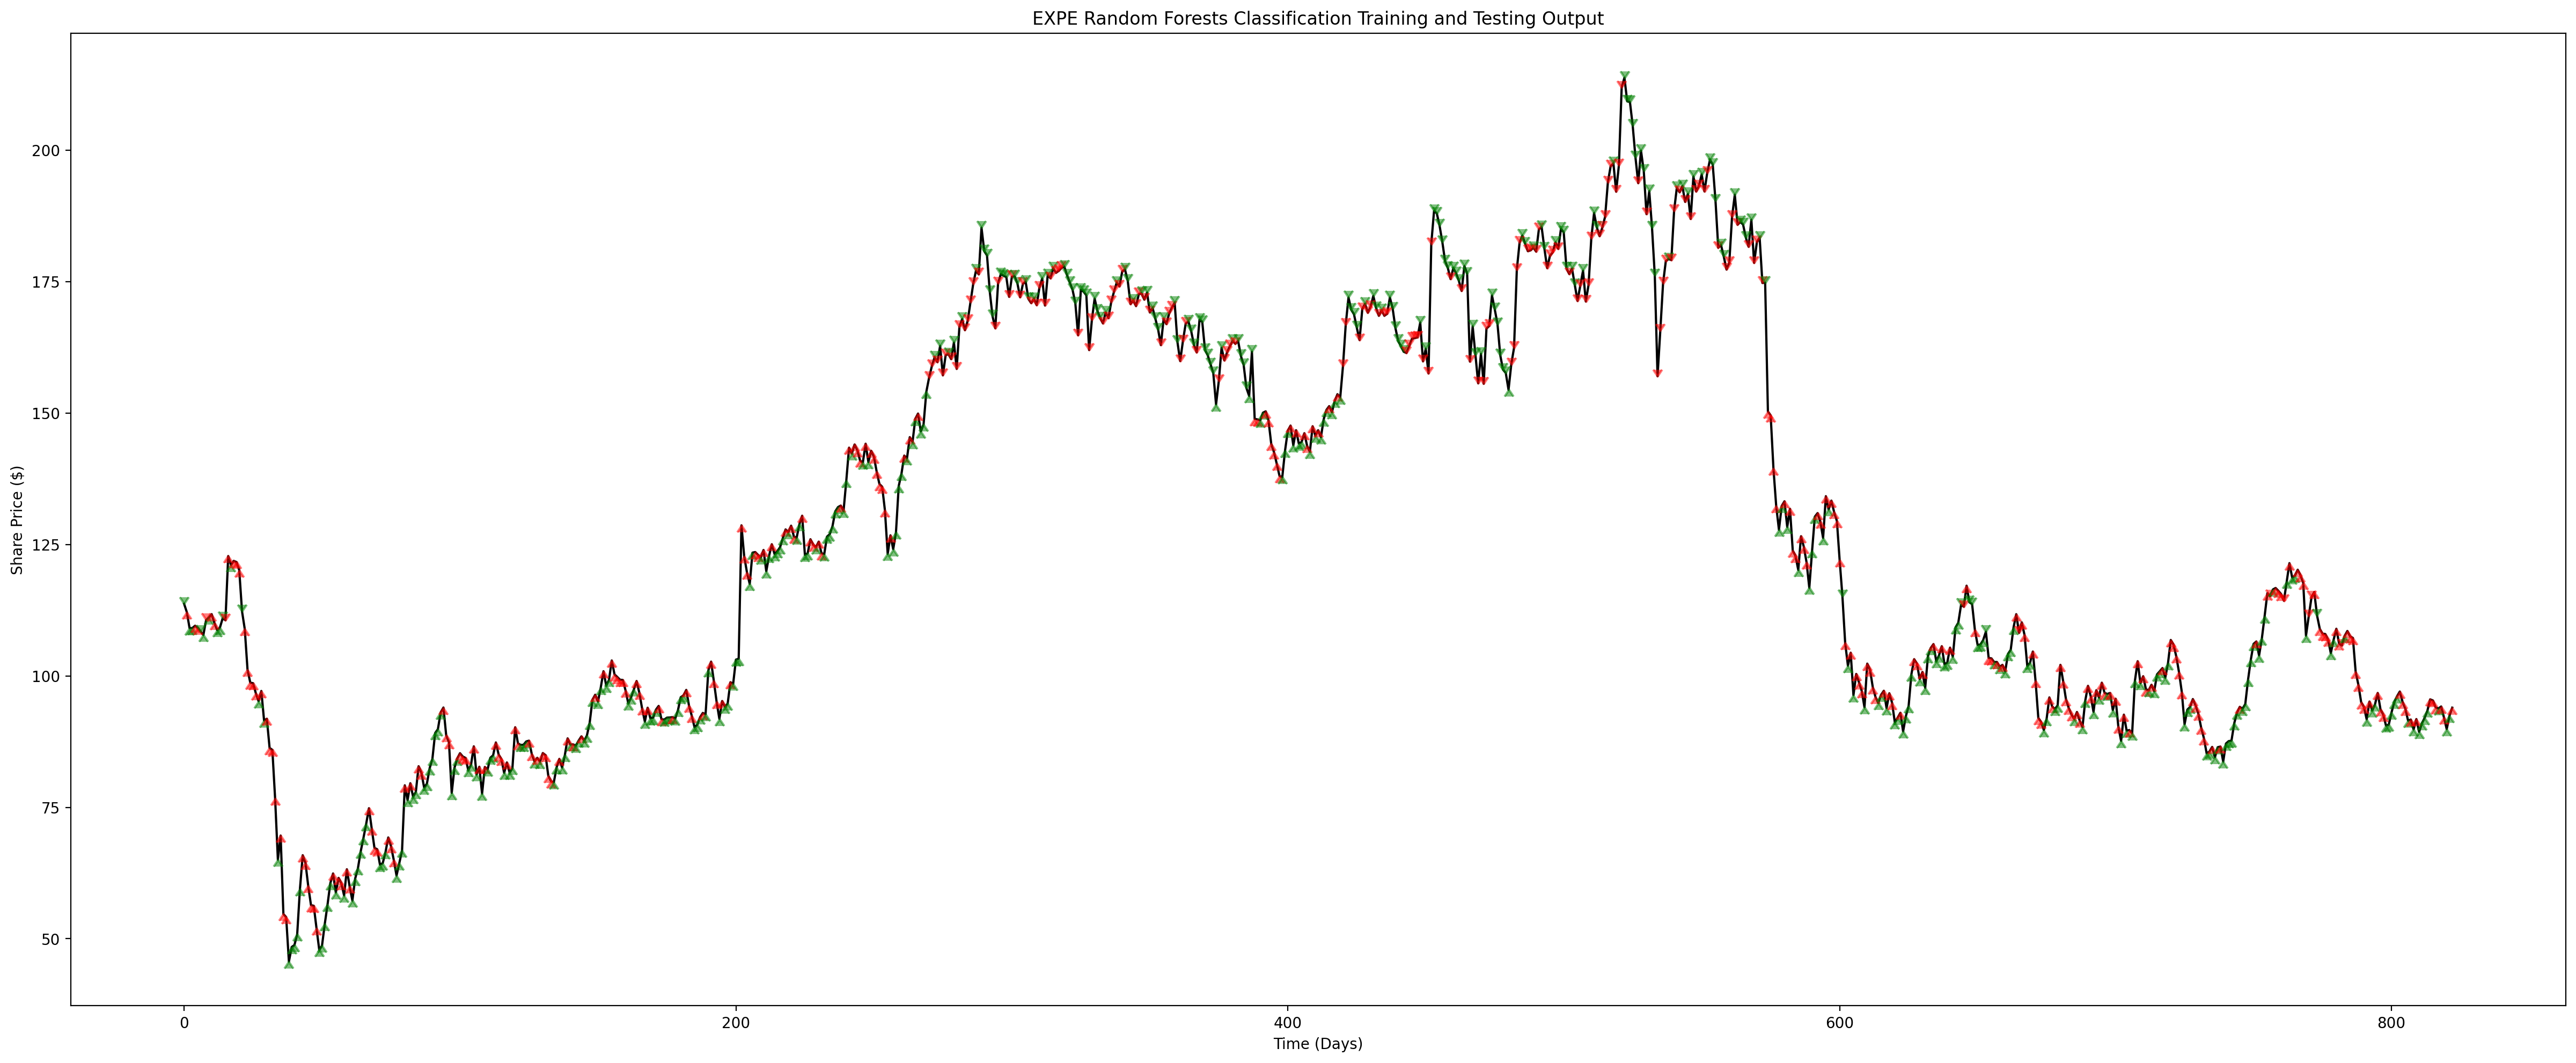

In [5]:
# Random Forest Model using classification (whether precition is 'Up' or 'Down')
randomForests = RandomForestClassifier(n_estimators=250, max_depth=9, bootstrap=False) # model
rFModel = randomForests.fit(xTrain, yTrainClass) # train

#predict
yRandomForestsPredict = rFModel.predict(xTest)
rfAccuracy = accuracy_score(yTestClass, yRandomForestsPredict)
print(rfAccuracy)

# graph
plt.figure(figsize=(30,12), dpi=dpiAmount)
plt.title(f"{ticker} Random Forests Classification Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(yRandomForestsPredict[idx]), color=getColors(yTestClass[idx], yRandomForestsPredict[idx]), zorder=2, alpha=0.5)


0.5151883353584447


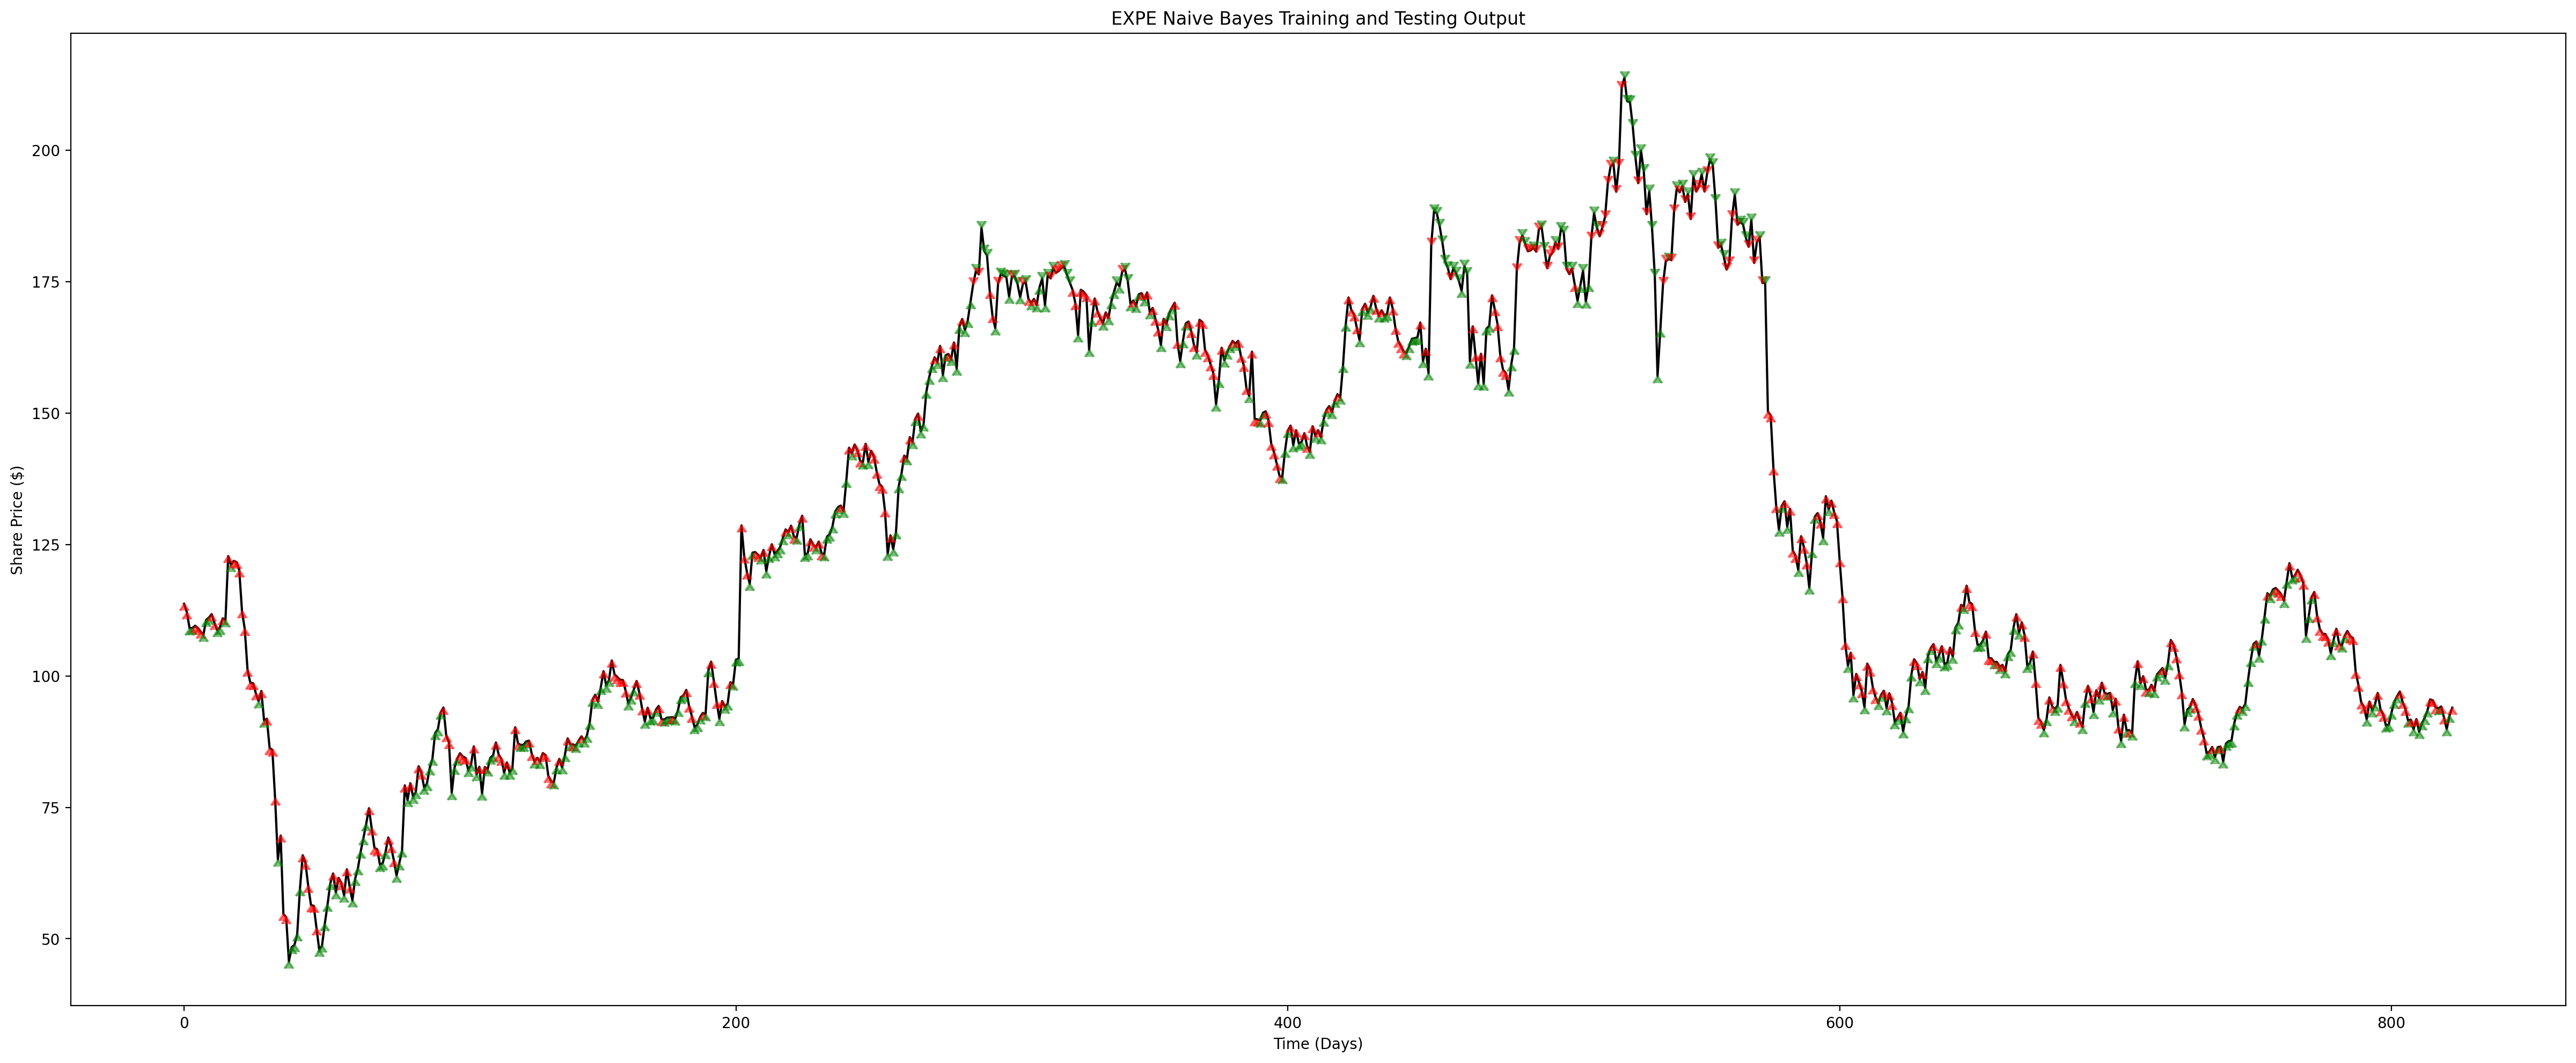

In [6]:
# Naive Bayes
classifier = GaussianNB() # model
bayesModel = classifier.fit(xTrain, yTrainClass) # train

# predict
yBayesPredict = bayesModel.predict(xTest)
bayesAccuracy = accuracy_score(yTestClass, yBayesPredict)
print(bayesAccuracy)

# graph
plt.figure(figsize=(30,12), dpi=dpiAmount)
plt.title(f"{ticker} Naive Bayes Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(yBayesPredict[idx]), color=getColors(yTestClass[idx], yBayesPredict[idx]), zorder=2, alpha=0.5)

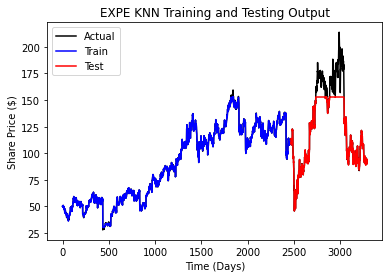

In [7]:
# KNN regression
knn = KNeighborsRegressor(n_neighbors=33, leaf_size=40, p=1, weights='uniform') # create model
knnModelRegress = knn.fit(xTrain, yTrainRegress) # train

# predict
trainKnnPredict = knnModelRegress.predict(xTrain)
yKnnPredict = knnModelRegress.predict(xTest)

# create plottable data
testPredictKnnPlot = np.empty_like(data['Close'])
testPredictKnnPlot[:] = np.nan
testPredictKnnPlot[len(trainKnnPredict):len(data)] = yKnnPredict

# Plot train and test predictions
plt.plot(data['Close'], color="black", label=f"Actual")
plt.plot(trainKnnPredict, color="blue", label=f"Train")
plt.plot(testPredictKnnPlot, color="red", label=f"Test")
plt.title(f"{ticker} KNN Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
plt.legend()
plt.show()

0.5236938031591738


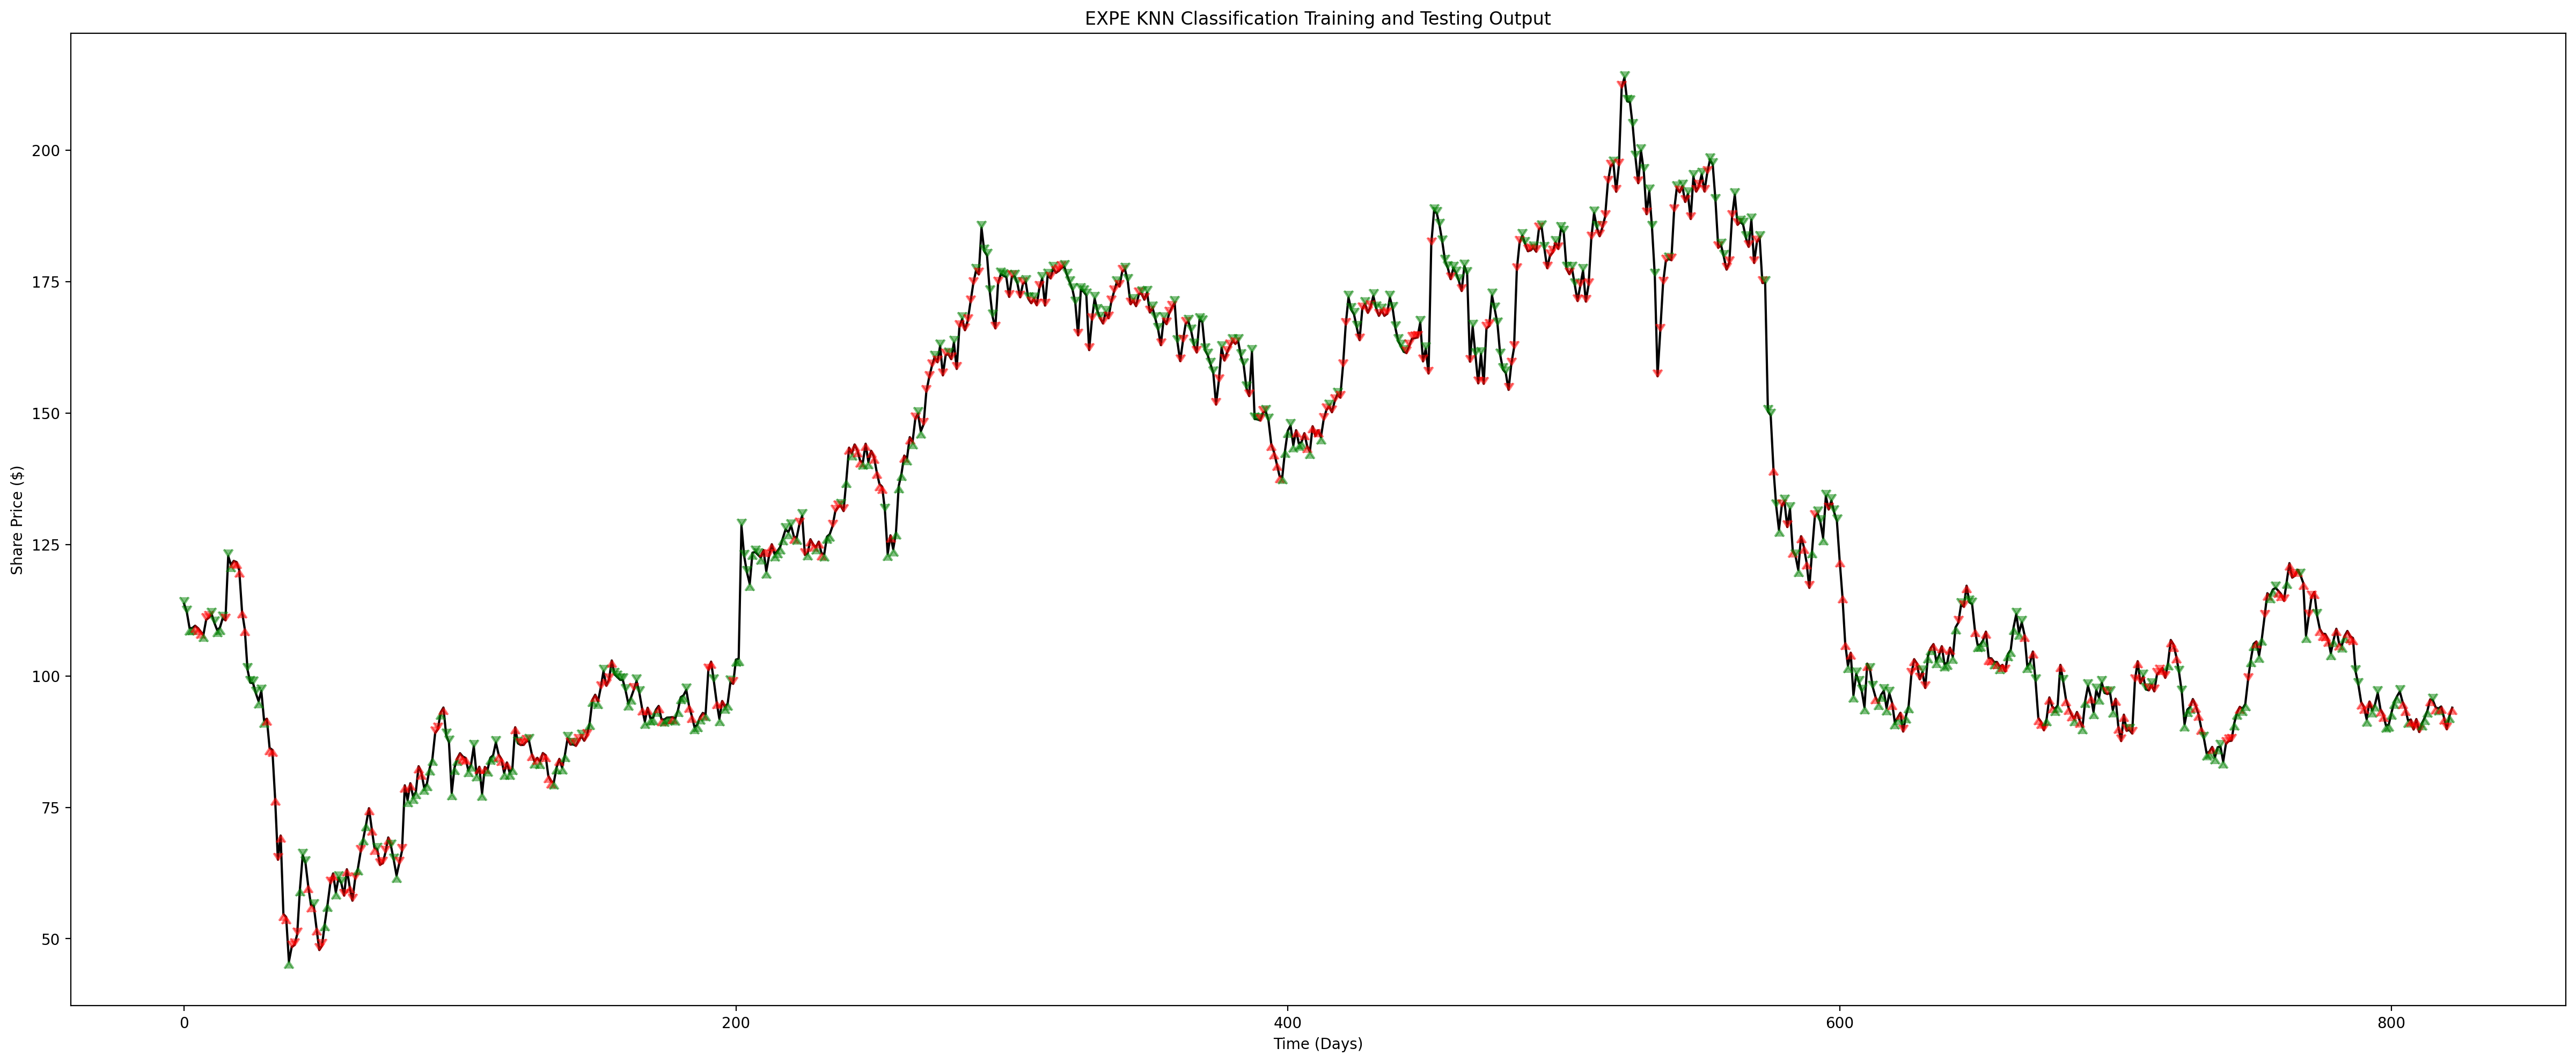

In [8]:
# KNN classifier - best k-value I've found: 33
knnModel = KNeighborsClassifier(n_neighbors=33, leaf_size=40, p=1, weights='uniform').fit(xTrain, yTrainClass) # create and train model

# predict
yKnnPredict = knnModel.predict(xTest)
knnAccuracy = accuracy_score(yTestClass, yKnnPredict)
print(knnAccuracy)

# graph
plt.figure(figsize=(30,12), dpi=dpiAmount)
plt.title(f"{ticker} KNN Classification Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(yKnnPredict[idx]), color=getColors(yTestClass[idx], yKnnPredict[idx]), zorder=2, alpha=0.5)

0.49696233292831105


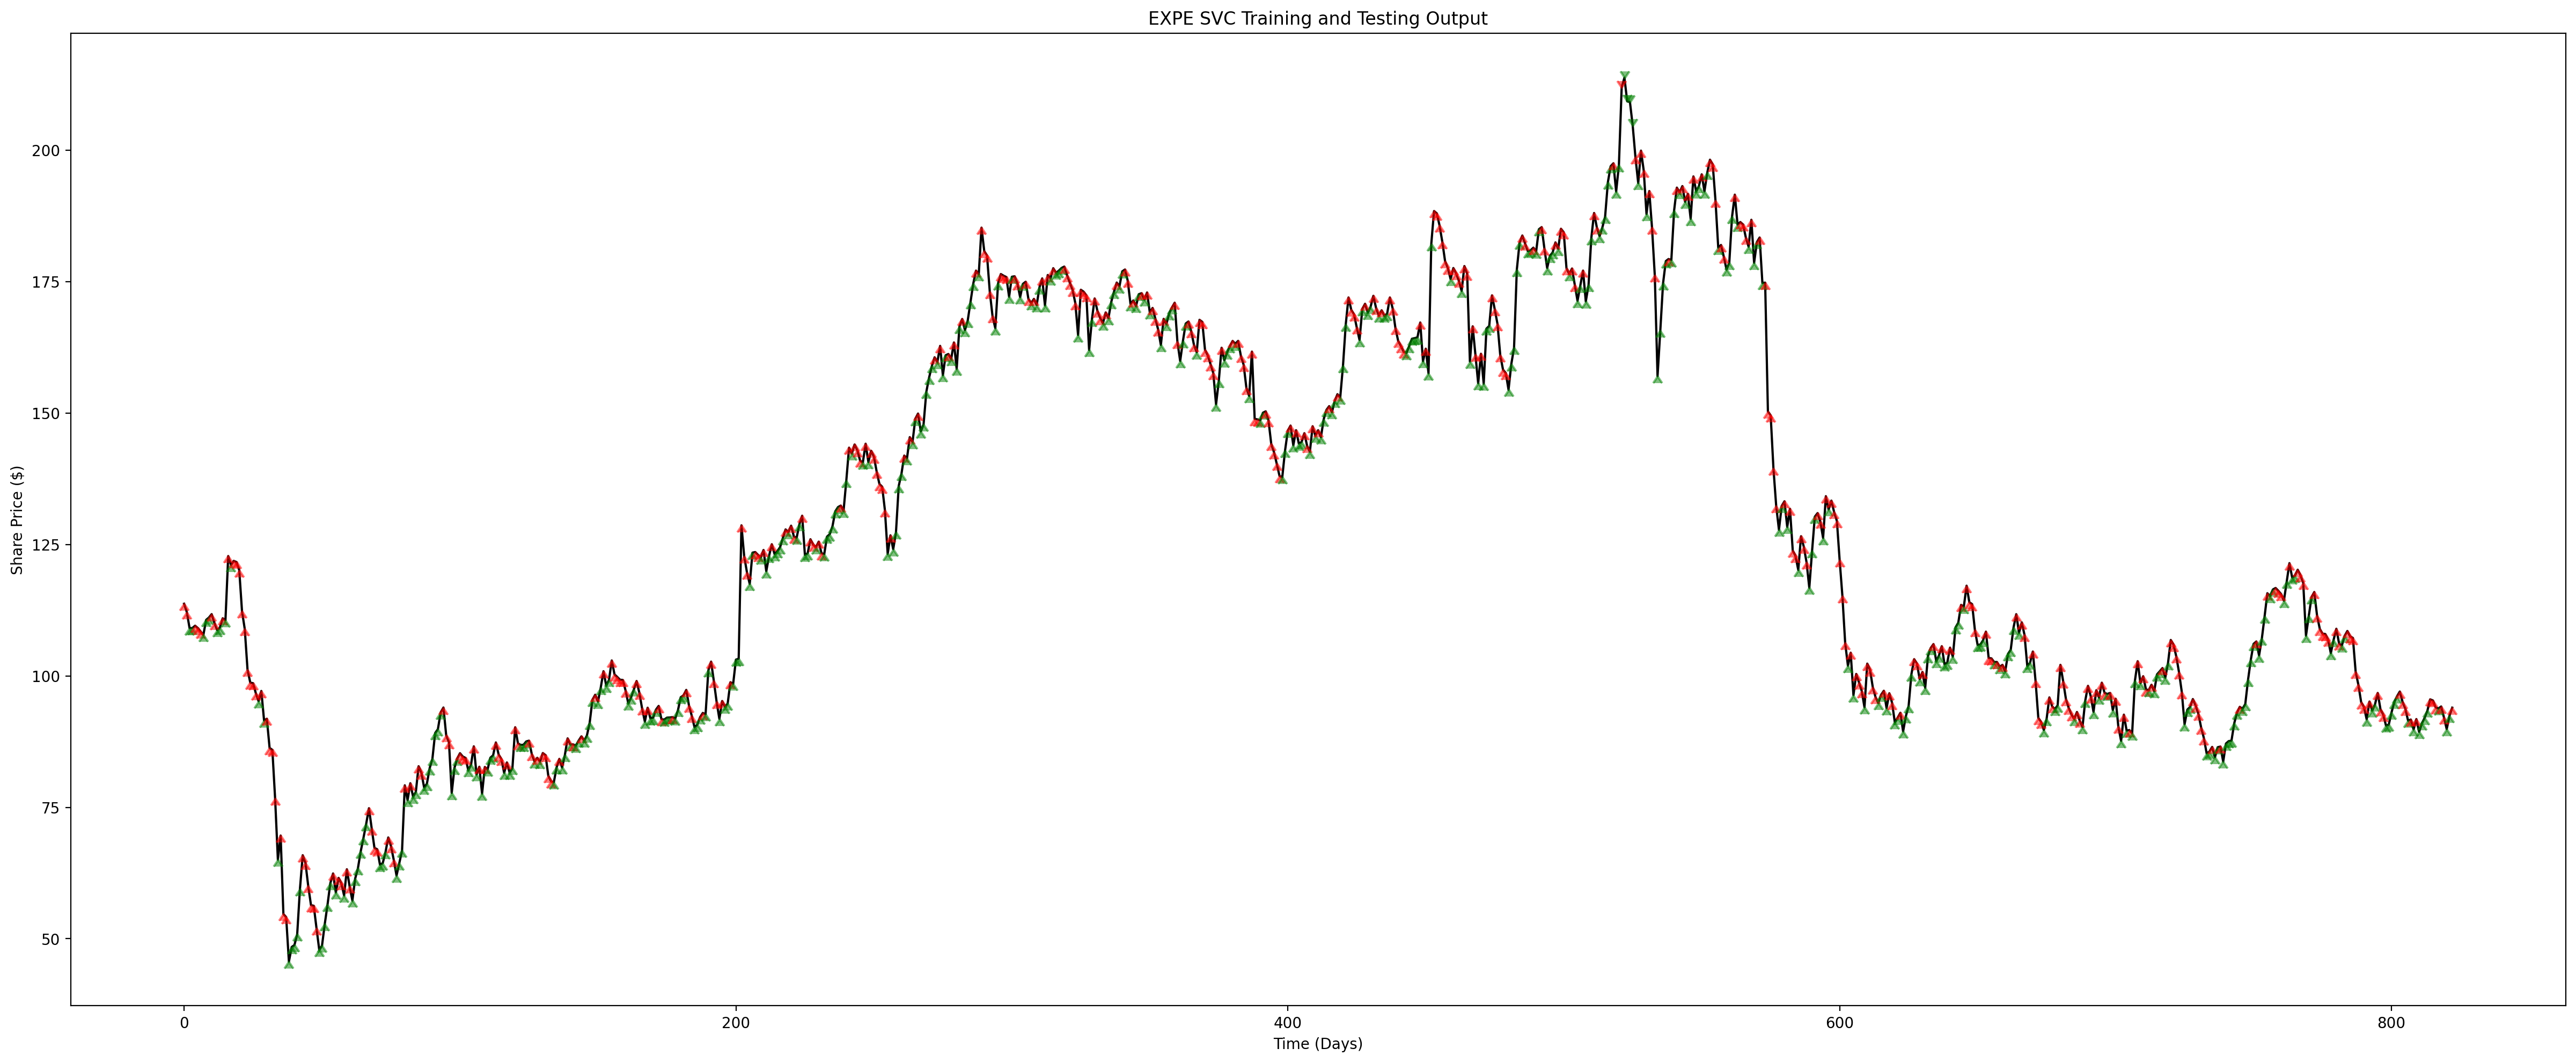

In [9]:
# LinearSVC
svc = LinearSVC(C=.0001, loss='hinge') # model
svcModel = svc.fit(xTrain, yTrainClass) # train

# predict
svcPredict = svcModel.predict(xTest)
svcAccuracy = accuracy_score(yTestClass, svcPredict)
print(svcAccuracy)

# graph
plt.figure(figsize=(30,12), dpi=dpiAmount)
plt.title(f"{ticker} SVC Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(svcPredict[idx]), color=getColors(yTestClass[idx], svcPredict[idx]), zorder=2, alpha=0.5)

0.5321992709599028


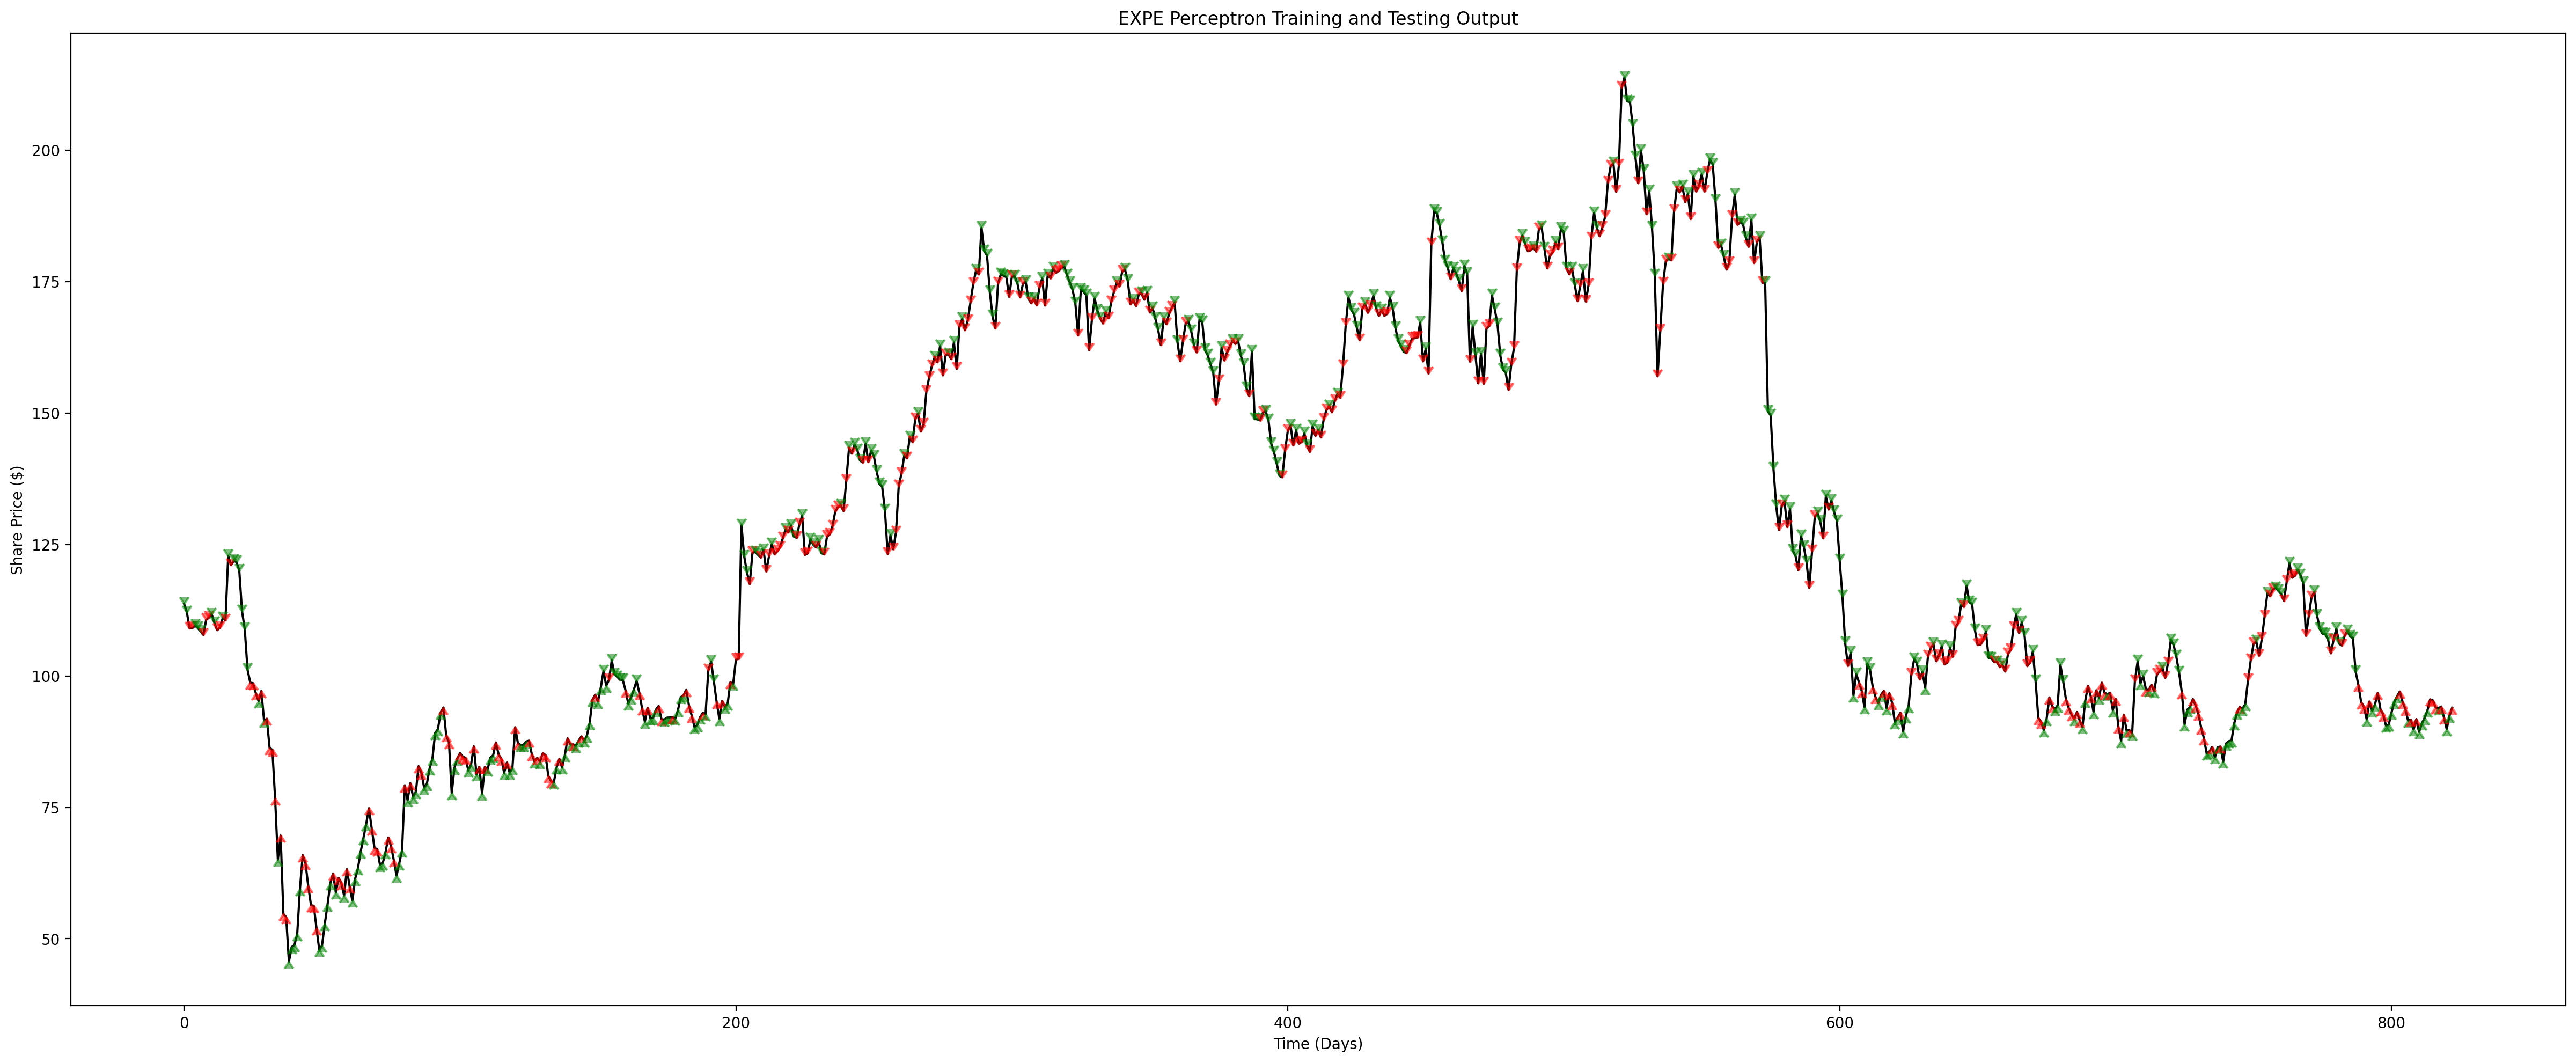

In [10]:
# Perceptron
percep = Perceptron(alpha=0, n_jobs=1, penalty='l2') # model
percepModel = percep.fit(xTrain, yTrainClass) # train

# predict
percepPredict = percepModel.predict(xTest)
percepAccuracy = accuracy_score(yTestClass, percepPredict)
print(percepAccuracy)

# graph
plt.figure(figsize=(30,12), dpi=dpiAmount)
plt.title(f"{ticker} Perceptron Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
data2 = data['Close'].iloc[-len(yTestClass):]
plt.plot(data2.reset_index(drop=True), color='black')
for idx, i in enumerate(data['Close'].iloc[-len(yTestClass):]):
    plt.scatter(idx, i, marker=getSymbols(percepPredict[idx]), color=getColors(yTestClass[idx], percepPredict[idx]), zorder=2, alpha=0.5)

In [11]:
# Predict 1 day into the future using all models
# Generalize and print out all the info a data analyst/stock investor may want to know from our models
from statistics import mode

# gather predictions
svcPredict = svcModel.predict(xTest[-1:])[0]
percepPredict = percepModel.predict(xTest[-1:])[0]
knnPredict = knnModel.predict(xTest[-1:])[0]
randomForestsPredict = rFModel.predict(xTest[-1:])[0]
bayesPredict = bayesModel.predict(xTest[-1:])[0]
overallPredictions = [percepPredict, knnPredict, randomForestsPredict, bayesPredict]

# gather numerical prediction
rfNumericalPredict = rFRegress.predict(xTest[-1:])[0]
knnNumericalPredict = knnModelRegress.predict(xTest[-1:])[0]

# print to user
currentStockPrice = yTestRegress[-1:].to_string(index=False)
currentStockPrice = "${:,.2f}".format(float(currentStockPrice))
print("Current Stock price: " + currentStockPrice)
print("Overall Future Direction Prediction: " + str(mode(overallPredictions)))

print("\nModel Predictions - ")
print("Random Forests: " + str(randomForestsPredict))
print("Naive Bayes: " + str(bayesPredict))
print("KNN: " + str(knnPredict))
print("SVC: " + str(svcPredict))
print("Perceptron: " + str(percepPredict))

rfNumericalPredict = "${:,.2f}".format(rfNumericalPredict)
knnNumericalPredict = "${:,.2f}".format(knnNumericalPredict)
print("\nFuture Stock Price Closing Estimates - ")
print("Random Forests: " + str(rfNumericalPredict))
print("KNN: " + str(knnNumericalPredict))

overallAccuracies = [rfAccuracy, bayesAccuracy, knnAccuracy, svcAccuracy, percepAccuracy]
print("\nAccuracy Scores - ")
print("Random Forests:", "{0:.2%}".format(rfAccuracy))
print("Naive Bayes:", "{0:.2%}".format(bayesAccuracy))
print("KNN:", "{0:.2%}".format(knnAccuracy))
print("SVC:", "{0:.2%}".format(svcAccuracy))
print("Perceptron:", "{0:.2%}".format(percepAccuracy))
print("Best Accuracey:", "{0:.2%}".format(max(overallAccuracies)))

Current Stock price: $93.96
Overall Future Direction Prediction: Up

Model Predictions - 
Random Forests: Up
Naive Bayes: Up
KNN: Up
SVC: Up
Perceptron: Up

Future Stock Price Closing Estimates - 
Random Forests: $93.99
KNN: $94.22

Accuracy Scores - 
Random Forests: 51.03%
Naive Bayes: 51.52%
KNN: 52.37%
SVC: 49.70%
Perceptron: 53.22%
Best Accuracey: 53.22%


The following is Parameter tuning (commented because they take several minutes to run). As well as an attempt at making a Keras Perceptron - it is left here for history purposes

In [12]:
# random forest parameter tuning - commented because it takes several minutes
# randomForestGrid = {
# 'n_estimators': [10, 20, 50, 100, 200, 250, 300, 400, 500],  
# 'max_depth': np.arange(1, 100, 1),  
# 'min_samples_split': [2, 5, 10], 
# 'min_samples_leaf': [1, 2, 4, 6, 8, 10],  
# 'bootstrap': [True, False], 
# 'random_state': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 42]
# }
# randomSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=randomForestGrid, cv=3, n_jobs=-1, verbose=2, n_iter=200) # randomCV using because the GridSearch takes way too long
# randomSearchFit = randomSearch.fit(xTrain, yTrainClass)
# print(randomSearchFit.best_params_)

In [13]:
# knn parameter tuning - commented because it takes several minutes

# knnGrid = { # what we want to test
# 'n_neighbors': [1, 2, 3, 4, 5, 8, 10, 15, 20, 30, 40, 50, 75, 100, 250, 500],  
# 'leaf_size': [10, 20, 30, 40],
# 'p' : [1, 2],
# 'weights' : ['uniform', 'distance']
# }

# gridSearch = GridSearchCV(KNeighborsClassifier(), knnGrid, cv=10, n_jobs=-1, verbose=2) # create grid model
# gridSearchFit = gridSearch.fit(xTrain, yTrainClass) # train all the possibilities
# print(gridSearchFit.best_params_)

In [14]:
# SVC parameter tuning - commented because it takes several minutes

# svcGrid = { # what we want to test
# 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
# 'loss': ['hinge', 'squared_hinge']
# }

# gridSearch = GridSearchCV(LinearSVC(), svcGrid, cv=10, n_jobs=-1, verbose=2) # create grid model
# gridSearchFit = gridSearch.fit(xTrain, yTrainClass) # train all the possibilities
# print(gridSearchFit.best_params_)

In [15]:
# Perceptron parameter tuning - commented because it takes several minutes

# percepGrid = { # what we want to test
# 'penalty': ['l2', 'l1', 'elasticnet', None],  
# 'alpha': [.0001, ],  
# 'shuffle' : [True, False],
# 'n_jobs' : [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 50, 100, None]
# }

# gridSearch = GridSearchCV(Perceptron(), percepGrid, cv=10, n_jobs=-1, verbose=2) # create grid model
# gridSearchFit = gridSearch.fit(xTrain, yTrainClass) # train all the possibilities
# print(gridSearchFit.best_params_)

In [16]:
# Failed Perceptron attempt using keras - will keep this here for now

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# perceptron via keras
model = Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(loss='MeanSquaredError', optimizer='adam')

model.fit(xTrain, yTrainRegress, validation_data=(xTest, yTestRegress), epochs=20, batch_size=64, verbose=1)

Epoch 1/20
39/39 [==============================] - 1s 9ms/step - loss: 9187.4561 - val_loss: 17113.6035
Epoch 2/20
39/39 [==============================] - 0s 3ms/step - loss: 9180.0146 - val_loss: 17096.4980
Epoch 3/20
39/39 [==============================] - 0s 3ms/step - loss: 9172.5742 - val_loss: 17080.6934
Epoch 4/20
39/39 [==============================] - 0s 3ms/step - loss: 9165.2031 - val_loss: 17064.2422
Epoch 5/20
39/39 [==============================] - 0s 3ms/step - loss: 9157.8037 - val_loss: 17048.4863
Epoch 6/20
39/39 [==============================] - 0s 4ms/step - loss: 9150.4170 - val_loss: 17032.6543
Epoch 7/20
39/39 [==============================] - 0s 4ms/step - loss: 9143.0527 - val_loss: 17016.3125
Epoch 8/20
39/39 [==============================] - 0s 4ms/step - loss: 9135.6426 - val_loss: 17001.0684
Epoch 9/20
39/39 [==============================] - 0s 4ms/step - loss: 9128.2930 - val_loss: 16984.2324
Epoch 10/20
39/39 [==============================] - 0s

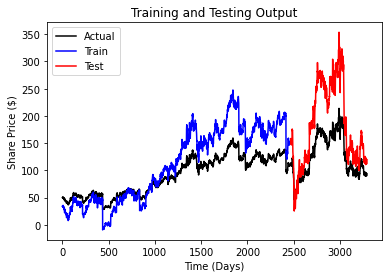

In [17]:
# Graphs for failed keras Perceptron above - might remove but left here for now

# predict train and test data
trainPrediction = model.predict(xTrain)
testPrediction = model.predict(xTest)

# reverse scaling
trainPrediction = standardizer.inverse_transform(trainPrediction)
testPrediction = standardizer.inverse_transform(testPrediction)

# flatten to 1D array
trainPrediction = trainPrediction.flatten()
testPrediction = testPrediction.flatten()

# put into plotable array
testPredictPlot = np.empty_like(data['Close'])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPrediction):len(data)] = testPrediction

# Plot train and test predictions
plt.plot(data['Close'], color="black", label=f"Actual")
plt.plot(trainPrediction, color="blue", label=f"Train")
plt.plot(testPredictPlot, color="red", label=f"Test")
plt.title("Training and Testing Output")
plt.xlabel("Time (Days)")
plt.ylabel("Share Price ($)")
plt.legend()
plt.show()